# AIOps Challenge
This notebook is for [AIOps Challenge](http://iops.ai/) which currently focus much on time series anomaly detection.
Baiscally, one gets a time series and try to identify anomalies within the time series.
The capability of an anomaly detector is measured through the correct identification of anomalies within $T$ time steps after any anomaly occur.

More details could be found in [Time Series Anomaly Detection](http://iops.ai/competition_detail/?competition_id=5&flag=1)

The procedure of time series anomaly detection follows:
* load libraries and data
* preprocess data
* train models
* test models and comparison

## Load libraries and data
Libraries include:
* numpy
* pandas
* keras
* sklearn
* matplotlib

Data come from [AIOps Challenge](http://iops.ai/) and include:
* train.csv: training dataset for phase 1 competition
* test.csv: testing dataset for phase 1 competition
* phase2_train.csv: training dataset for phase 2 competition
* phase2_ground_true.csv: testing dataset for phase 2 competition

It is worth noting that, the datasets contain missing data etc.

In this ipython nootbook, **we target at processing phase2 datasets** because it provides ground true data for model testing.

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Input data files are available in the "../input/" directory.
# For example, running this will list the files in the input directory
print(os.listdir("../input"))

import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import keras
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import time

# Any results you write to the current directory are saved as output.

['test.csv', 'phase2_ground_truth.hdf', 'phase2_train.csv', 'train.csv']


/home/yz506/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def show_dataset_info(dataframe):
    """
    get a pandas dataframe as input and print the information.
    """
    # show basic info of the phase 2 training dataset
    print(dataframe.columns, '\n')
    print(dataframe.describe(), '\n')
    print(dataframe.head(), '\n')

In [3]:
# read datasets as pandas dataframes
phase2_train = pd.read_csv('../input/phase2_train.csv')
phase2_test = pd.read_hdf('../input/phase2_ground_truth.hdf')

In [4]:
show_dataset_info(phase2_train)
show_dataset_info(phase2_test)

Index(['timestamp', 'value', 'label', 'KPI ID'], dtype='object') 

          timestamp         value         label
count  3.004066e+06  3.004066e+06  3.004066e+06
mean   1.495420e+09  5.059672e+01  2.648211e-02
std    5.426934e+06  6.104686e+01  1.605641e-01
min    1.467302e+09 -3.011022e+00  0.000000e+00
25%    1.493983e+09  3.062500e+00  0.000000e+00
50%    1.496416e+09  3.192000e+01  0.000000e+00
75%    1.498642e+09  4.843000e+01  0.000000e+00
max    1.502343e+09  1.189250e+03  1.000000e+00 

    timestamp     value  label                                KPI ID
0  1476460800  0.012604      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
1  1476460860  0.017786      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
2  1476460920  0.012014      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
3  1476460980  0.017062      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
4  1476461040  0.023632      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd 

Index(['timestamp', 'value', 'label', 'KPI ID'], dtype='object') 

          timest

## Preprocessing
Because the datasets we loaded contains multiple time series, to perform time series anomaly detection, we should **extract** different time series from the datasets in the first place. Also, we have to perform normalization and etc to make sure the method we used later could **generalize** well in different datasets. The preprocess may contain:
* time series extraction
* time series normalization
* time series imputation (optional - fill missing data)
* time series windowize (optional)
* time series oversampling/undersampling for different classes of data
* ...

One may refer to [The Winner](http://workshop.aiops.org/files/logicmonitor2018.pdf) of the AIOps Challenge for more details.

From this part, we focus on the preprocess of *phase2_training*.

### Time Series Extraction
From the '../input/train.csv' file, we read a huge matrix:

| timestamp | value | label |  KPI ID |
|:-------------:|:------:|:------:|:------------:|
|     100500200     |  0.525 |   0  | 33fd3322e |
|     100500260     |  0.335 |   0  | 33fd3322e |
|     100500320     |  0.225 |   0  | 33fd3322e |
|     200100320     |  5.225 |   0  | 45dii4833 |
|     200100330     |  4.225 |   0  | 45dii4833 |
-

We have to extract different time series from the huge matrix according to the KPI ID.

To this end, we utilize np.unique() to get the unique KPI ID and the index of the unique KPI ID to extract the time series.

In [5]:
def get_time_series_from_dataframe(dataframe):
    """
    extract the time series set from given dataframe.
    """
    # training time series extraction
    ts_ids, ts_indexes, ts_point_counts = np.unique(dataframe['KPI ID'],
                                                    return_index=True,
                                                    return_counts=True)
    print('Extract are %d time series in the dataframe:' %(len(ts_ids)))

    # extract time series using ts_indexes
    ts_indexes.sort()
    ts_indexes = np.append(ts_indexes, len(dataframe))   # full ranges for extracting time series

    set_of_time_series = []
    set_of_time_series_label = []

    for i in np.arange(len(ts_indexes)-1):
        print('Extracting %d th time series with index %d and %d (exclusive)'
              %(i, ts_indexes[i], ts_indexes[i+1]))
        set_of_time_series.append(np.asarray(dataframe['value']
                                             [ts_indexes[i]:ts_indexes[i+1]]))
        set_of_time_series_label.append(np.asarray(dataframe['label']
                                                  [ts_indexes[i]:ts_indexes[i+1]]))
        
    return set_of_time_series, set_of_time_series_label

In [6]:
train_time_series_dataset, \
train_time_series_dataset_label = get_time_series_from_dataframe(phase2_train)
print()
test_time_series_dataset,\
test_time_series_dataset_label = get_time_series_from_dataframe(phase2_test)

Extract are 29 time series in the dataframe:
Extracting 0 th time series with index 0 and 107717 (exclusive)
Extracting 1 th time series with index 107717 and 116501 (exclusive)
Extracting 2 th time series with index 116501 and 127639 (exclusive)
Extracting 3 th time series with index 127639 and 136505 (exclusive)
Extracting 4 th time series with index 136505 and 145368 (exclusive)
Extracting 5 th time series with index 145368 and 154152 (exclusive)
Extracting 6 th time series with index 154152 and 162936 (exclusive)
Extracting 7 th time series with index 162936 and 171720 (exclusive)
Extracting 8 th time series with index 171720 and 300712 (exclusive)
Extracting 9 th time series with index 300712 and 429584 (exclusive)
Extracting 10 th time series with index 429584 and 558594 (exclusive)
Extracting 11 th time series with index 558594 and 687378 (exclusive)
Extracting 12 th time series with index 687378 and 816165 (exclusive)
Extracting 13 th time series with index 816165 and 944954 (e

After extracting training time series dataset and testing time series dataset, we place them in the lists:
* train_time_series_dataset, a **list** of time series each of which contains an **array** of values (time series)
* train_time_series_dataste_label, a **list** of time series labels each of which contains an **array** of binary values (label)
* test_time_series_dataset
* test_time_series_dataset_label

### Time Series Normalization
After extracting the time series and place them all in *time_series_dataset*, we ought to normalize them.
Note that what we have now are the following variables:
* time_series_dataset: a list of arrays each of which maintains a **time series**
* time_series_dataset_label: a list of arrays each of which maintains the **labels** for the corresponding time series
* time_series_dataset_size: the **number of time series** in the list time_series_dataset

After normalization, we will use **time_series_dataset_scaled** instead of time_series_dataset

In [7]:
def plot_time_series_info(set_of_time_series, set_of_time_series_scaled, set_of_time_series_label, index):
    """
    plot a time series from the given set of time series using the given index
    """
    assert(len(set_of_time_series) == len(set_of_time_series_scaled) == len(set_of_time_series_label))
    
    index_revised = index % len(set_of_time_series)
    ts = set_of_time_series[index_revised]
    ts_scaled = set_of_time_series_scaled[index_revised]
    ts_label = set_of_time_series_label[index_revised]
    
    plt.subplot(3,1,1)
    plt.plot(ts, 'r')
    plt.subplot(3,1,2)
    plt.plot(ts_scaled, 'b')
    plt.subplot(3,1,3)
    plt.plot(ts_label, 'k')
    plt.show()

Here is a training example of a time series after/before scaling/normalization/transforming:


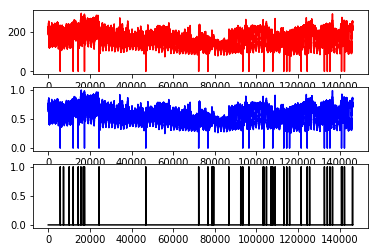

Here is a testing example of a time series after/before scaling/normalization/transforming:


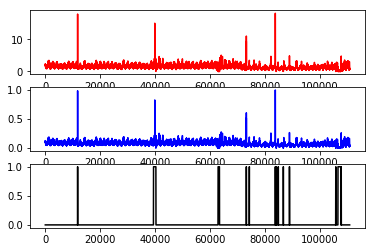

In [8]:
# import library to preprocess time series
# there is a big number of scalers, normalizers and transformers that could be of help
# pick one of them to maximize the anomaly detection performance in a specific application
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import maxabs_scale

import random

# here we use the basic one (minmax_scale()) to get the baseline performance
train_time_series_dataset_size = len(train_time_series_dataset)
test_time_series_dataset_size = len(test_time_series_dataset)

train_time_series_dataset_scaled = []
test_time_series_dataset_scaled = []

for i in np.arange(train_time_series_dataset_size):
    train_time_series_dataset_scaled.append(minmax_scale(train_time_series_dataset[i]))
    
for i in np.arange(test_time_series_dataset_size):
    test_time_series_dataset_scaled.append(minmax_scale(test_time_series_dataset[i]))

# plot an example after scaling/normalization/transforming, random index
print('Here is a training example of a time series after/before scaling/normalization/transforming:')
plot_time_series_info(train_time_series_dataset, 
                      train_time_series_dataset_scaled,
                      train_time_series_dataset_label,
                      random.randint(0,train_time_series_dataset_size))

print('Here is a testing example of a time series after/before scaling/normalization/transforming:')
plot_time_series_info(test_time_series_dataset,
                      test_time_series_dataset_scaled, 
                      test_time_series_dataset_label,
                      random.randint(0,test_time_series_dataset_size))

### Feature Engineering and Sampling
After the normalization of the time series, **feature engineering** is followed to make the dataset more compact and informative for classification. Also, the **oversampling** should be used to deal with the imbalance dataset for classification.

1) The detailed methodology for feature engineering is following the preprocessing procedure in the design of [The Winner](http://workshop.aiops.org/files/logicmonitor2018.pdf) of the [AIOps Challenge](http://iops.ai/competition_detail/?competition_id=5&flag=1). For determining the abnormality of the data point in time step $T$, we are examining the following features:
* the 4 types of residuals (SARIMAX, SimpleExponentialSmoothing, SimpleExponentialSmoothing(add), Holt):
$$
f_{residual} = x_{T} - fittedvalue_{T}
$$
* the logarithm of the original time series:
$$
f_{log} = log(x_{T})
$$
* the difference of the original time series:
$$
f_{diff} = x_{T} - x_{T-1}
$$
* the percentage of the difference:
$$
f_{percent} = \frac{f_{diff}}{x_{T-1}}
$$
* the difference of difference
$$
f_{diff2} = f_{diff} - (x_{T-1} - x_{T-2})
$$
* the difference of current time series with accumulated mean
$$
f_{diff3} = x_{T} - accumulated_mean
$$

The following features are associated with different window sizes:
* the mean of the sliding window which is of size $W$:
$$
f_1 = mean([x_{T-W}, x_{T-W+1}, \cdots, x_T])
$$
* the variance of the sliding window which is of size $W$:
$$
f_2 = var([x_{T-W}, x_{T-W+1}, \cdots, x_T])
$$
* the difference between the means of time window to $T$ and $T-1$:
$$
f_3 = mean([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - mean([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])
$$
* the percentage of the different between the means of time window to $T$ and $T-1$:
$$
f_4 = \frac{mean([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - mean([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])}{mean([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}]}
$$
* the difference between the vars of time window to $T$ and $T-1$:
$$
f_5 = var([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - var([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])
$$
* the percentage of the different between the vars of time window to $T$ and $T-1$:
$$
f_6 = \frac{var([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - var([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])}{var([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}]}
$$
* the difference between the means of sliding windows from time step $T-W$ to $T$ and $T-2W$ to $T-W$:
$$
f_7 = mean([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - mean([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])
$$
* the change ratio between the means of sliding windows from time step $T-W$ to $T$ and $T-2W$ to $T-W$:
$$
f_8 = \frac{mean([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - mean([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])}{mean([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])}
$$
* the difference between the variances of sliding windows from time step $T-W$ to $T$ and $T-2W$ to $T-W$:
$$
f_9 = var([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - var([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])
$$
* the change ratio between the variances of sliding windows from time step $T-W$ to $T$ and $T-2W$ to $T-W$:
$$
f_{10} = \frac{var([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - var([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])}{var([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])}
$$
* the difference between the current value and mean of the window from time step $T-W-1$ to $T-1$:
$$
f_{11} = x_{T} - mean([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])
$$
* the difference between the current value and mean of the window from time step $T-2W$ to $T-W$:
$$
f_{12} = x_{T} - mean([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])
$$

Therefore, there at least exist 9+12 features for our classification purpose. With the selection of distinct $n$ sliding window sizes, i.e., $W_1, W_2, \cdots, W_n$, we are able to create $12n+9$ features in order to capture the key information of a data instance for anomaly detection.

2) The sampling methodology is using a over-sampling to pick multiple times of anomalies to fill the pool of labeled dataset for classification. This is to overcome the challenge of imbalance dataset for better performance in classification. A concrete survey concerning the methods handling imbalance dataset could be found [Here](https://www.sciencedirect.com/science/article/pii/S0031320318300931).

**We currently do not use oversampling, please neglect the following paragraph**

More specifically, whenever we encounter an anomalous point, we add it into the final labeled dataset/pool 25 times (This is because [The Winner](http://workshop.aiops.org/files/logicmonitor2018.pdf) said that the overall percentages of the abnormal data in the original dataset is 2%. We just want to pick a medium number to balance the dataset). For critical anomalous points, we also mark them and add another 25 times of them into the final labeled dataset. The threshold to determine critical anomalous points are set to 7, i.e., the first 7 anomalous points in a sequential set of anomalous points.

In [9]:
from statsmodels.tsa.api import SARIMAX, ExponentialSmoothing, SimpleExpSmoothing, Holt

In [10]:
def get_feature_logs(time_series):
    return np.log(time_series + 1e-2)

In [11]:
def get_feature_SARIMA_residuals(time_series):
    predict = SARIMAX(time_series,
                      trend='n', 
                      order=(5,1,1), 
                      measurement_error=True).fit().get_prediction()
    return time_series - predict.predicted_mean

def get_feature_AddES_residuals(time_series):
    predict = ExponentialSmoothing(time_series, trend='add').fit(smoothing_level=1)
    return time_series - predict.fittedvalues

def get_feature_SimpleES_residuals(time_series):
    predict = SimpleExpSmoothing(time_series).fit(smoothing_level=1)
    return time_series - predict.fittedvalues

def get_feature_Holt_residuals(time_series):
    predict = Holt(time_series).fit(smoothing_level=1)
    return time_series - predict.fittedvalues

In [12]:
def get_features_and_labels_from_a_time_series(time_series, time_series_label, Windows, delay):
    """
    Input: time_series, time_series_label, Window, delay (for determining vital data)
    
    In a time series dataset, it maintains a list of values.
    We'll convert the list of values into a list of feature vectors,
    each feature vector corresponds to a time point in the time series.
    
    For example: a time series [1,2,3,4,5] --> a featured dataset [[1,2,3],[2,3,4],[3,4,5]] (use one window size 3)
    
    The labels for the feature vectors are remained and returned.
    
    time_series: a list of values, an array
    time_series_label: a list of labels, an array
    Windows: the window sizes for time series feature extraction, an array
    delay: the maximum delay for effectively detect an anomaly
    
    Output: features_for_the_timeseries (a list of arrays), 
            labels_for_the_timeseries (a list of arrays), 
            vital_labels_for_the_timeseries (a list of arrays)
    """    
    data = []
    data_label = []
    data_label_vital = []
    
    start_point = 2*max(Windows)
    start_accum = 0
    
    # features from tsa models
    time_series_SARIMA_residuals = get_feature_SARIMA_residuals(time_series)
    time_series_AddES_residuals = get_feature_AddES_residuals(time_series)
    time_series_SimpleES_residuals = get_feature_SimpleES_residuals(time_series)
    time_Series_Holt_residuals = get_feature_Holt_residuals(time_series)
    
    # features from tsa models for time series logarithm
    time_series_logs = get_feature_logs(time_series)
    
    for i in np.arange(start_point, len(time_series)):        
        # the datum to put into the data pool
        datum = []
        datum_label = time_series_label[i]        
        
        # fill the datum with f01-f09
        diff_plain = time_series[i] - time_series[i-1]
        start_accum = start_accum + time_series[i]
        mean_accum = (start_accum)/(i-start_point+1)
        
        # f01-f04: residuals
        datum.append(time_series_SARIMA_residuals[i])
        datum.append(time_series_AddES_residuals[i])
        datum.append(time_series_SimpleES_residuals[i])
        datum.append(time_Series_Holt_residuals[i])
        # f05: logarithm
        datum.append(time_series_logs[i])
        
        # f06: diff
        datum.append(diff_plain)
        # f07: diff percentage
        datum.append(diff_plain/(time_series[i-1] + 1e-10))  # to avoid 0, plus 1e-10
        # f08: diff of diff - derivative
        datum.append(diff_plain - (time_series[i-1] - time_series[i-2]))
        # f09: diff of accumulated mean and current value
        datum.append(time_series[i] - mean_accum)

        # fill the datum with features related to windows
        # loop over different windows size to fill the datum
        for k in Windows:
            mean_w = np.mean(time_series[i-k:i+1])
            var_w = np.mean((np.asarray(time_series[i-k:i+1]) - mean_w)**2)
            #var_w = np.var(time_series[i-k:i+1])
            
            mean_w_and_1 = mean_w + (time_series[i-k-1]-time_series[i])/(k+1)
            var_w_and_1 = np.mean((np.asarray(time_series[i-k-1:i]) - mean_w_and_1)**2)
            #mean_w_and_1 = np.mean(time_series[i-k-1:i])
            #var_w_and_1 = np.var(time_series[i-k-1:i])
            
            mean_2w = np.mean(time_series[i-2*k:i-k+1])
            var_2w = np.mean((np.asarray(time_series[i-2*k:i-k+1]) - mean_2w)**2)
            #var_2w = np.var(time_series[i-2*k:i-k+1])
            
            # diff of sliding windows
            diff_mean_1 = mean_w - mean_w_and_1
            diff_var_1 = var_w - var_w_and_1
            
            # diff of jumping windows
            diff_mean_w = mean_w - mean_2w
            diff_var_w = var_w - var_2w
            
            # f1
            datum.append(mean_w)  # [0:2] is [0,1]
            # f2
            datum.append(var_w)
            # f3
            datum.append(diff_mean_1)
            # f4
            datum.append(diff_mean_1/(mean_w_and_1 + 1e-10))
            # f5
            datum.append(diff_var_1)
            # f6
            datum.append(diff_var_1/(var_w_and_1 + 1e-10))
            # f7
            datum.append(diff_mean_w)
            # f8
            datum.append(diff_mean_w/(mean_2w + 1e-10))
            # f9
            datum.append(diff_var_w)
            # f10
            datum.append(diff_var_w/(var_2w + 1e-10))
            
            # diff of sliding/jumping windows and current value
            # f11
            datum.append(time_series[i] - mean_w_and_1)
            # f12
            datum.append(time_series[i] - mean_2w)

        data.append(np.asarray(datum))
        data_label.append(np.asarray(datum_label))

        # an important step is to identify the start anomalous points which are said to be critical
        # if the anomaly is detected within delay window of the occurence of the first anomaly
        if datum_label == 1 and sum(time_series_label[i-delay:i]) < delay:
            data_label_vital.append(np.asarray(1))
        else:
            data_label_vital.append(np.asarray(0))
            
    return data, data_label, data_label_vital

In [13]:
num_of_feature_with_value = 9
num_of_feature_with_window = 12

In [14]:
def get_expanded_featuers_and_labels(data_pool, data_pool_label, data_pool_label_vital, oversample=0):
    
    assert(len(data_pool) == len(data_pool_label) == len(data_pool_label_vital))

    if oversample == 0:
        return data_pool, data_pool_label
    
    data_pool_len = len(data_pool)
    
    # the data points and labels to be appended into the data/label pool
    data_pool_plus = []
    data_pool_plus_label = []
    for i in np.arange(data_pool_len):
        if data_pool_label[i] == 1: # anomalous point
            data_pool_plus.append(data_pool[i])
            data_pool_plus_label.append(data_pool_label[i])

    # the data points and labels to be appended into the data/label pool (critical ones)
    data_pool_vital = []
    data_pool_vital_label = []
    for i in np.arange(data_pool_len):
        if data_pool_label_vital[i] == 1: # vital anomalous point
            data_pool_vital.append(data_pool[i])
            data_pool_vital_label.append(data_pool_label_vital[i])

    # oversample abnormal data instances and vital abnormal data instances to balance the dataset
    data_pool_complete = data_pool + \
                         oversample * data_pool_plus + \
                         oversample * data_pool_vital

    data_pool_complete_label = data_pool_label + \
                               oversample * data_pool_plus_label + \
                               oversample * data_pool_vital_label

    assert(len(data_pool_complete) == len(data_pool_complete_label))
    print('The augment size of the dataset: %d = %d + %d * %d + %d * %d' %(len(data_pool_complete),
                                                                           len(data_pool),
                                                                           oversample,
                                                                           len(data_pool_plus),
                                                                           oversample,
                                                                           len(data_pool_vital)))

    # data_pool_complete (X) and data_pool_complete_label (y) should be ready for training
    return data_pool_complete, data_pool_complete_label

#### Training dataset generation
We generate the training dataset as a big data pool. All the feature vectors are inside this pool regard less of their sequential information. The training dataset maintains redundant data points due to over sampling.

In [15]:
# 1) feature engineering for training dataset
# specify the set of window sizes
# the maximum number is 125 means the start point to consider anomalies is 250, i.e., max(2W).
W = np.asarray([2, 5, 10, 25, 50, 100, 200, 300, 400, 500])
delay = 7

# training: data pool for labeled data points (presented by 6n+2 features)
train_data_pool = []
train_data_pool_label = []
train_data_pool_label_vital = []

# loop over all the time series
for i in np.arange(train_time_series_dataset_size):    
    # loop over all the data points in each time series
    data, \
    data_label, \
    data_label_vital = get_features_and_labels_from_a_time_series(train_time_series_dataset_scaled[i],
                                                                  train_time_series_dataset_label[i],
                                                                  W, delay)
    train_data_pool = train_data_pool + list(scale(np.asarray(data)))
    #train_data_pool = train_data_pool + list(minmax_scale(abs(np.asarray(data))))
    #train_data_pool = train_data_pool + list(maxabs_scale(np.asarray(data)))
    
    train_data_pool_label = train_data_pool_label + data_label
    train_data_pool_label_vital = train_data_pool_label_vital + data_label_vital
    
# 2) over sampling
# the methodology to achieve over sampling is to pick samples from train_data according to train_data_label
# data_pool + data_pool_plus + data_pool_vital, there are three datasets to be merged
# data_pool_label + data_pool_plus_label + data_pool_vital_label, there are three label datasets to be merged
train_data_pool_complete, \
train_data_pool_complete_label = get_expanded_featuers_and_labels(train_data_pool, 
                                                                  train_data_pool_label, 
                                                                  train_data_pool_label_vital)

# default oversampling is set to 0, so we do not use oversampling currenlty.

/home/yz506/anaconda3/envs/py3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yz506/anaconda3/envs/py3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yz506/anaconda3/envs/py3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yz506/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/yz50

In [16]:
"""
#### store the data_pool and data_pool_flag into csv file
train_data_pool_df = pd.DataFrame(train_data_pool)
train_data_pool_df.to_csv('train_data.csv', index=False)
train_data_pool_label_df = pd.DataFrame(train_data_pool_label)
train_data_pool_label_df.to_csv('train_data_label.csv', index=False)
train_data_pool_label_vital_df = pd.DataFrame(train_data_pool_label_vital)
train_data_pool_label_vital_df.to_csv('train_data_label_vital.csv', index=False)

#### read training dataset as pandas dataframes
train_data_pool_df = pd.read_csv('train_data.csv')
train_data_pool = list(np.asarray(train_data_pool_df))
train_data_pool_label_df = pd.read_csv('train_data_label.csv')
train_data_pool_label = list(np.asarray(train_data_pool_label_df))
train_data_pool_label_vital_df = pd.read_csv('train_data_label_vital.csv')
train_data_pool_label_vital = list(np.asarray(train_data_pool_label_vital_df))
"""

"\n#### store the data_pool and data_pool_flag into csv file\ntrain_data_pool_df = pd.DataFrame(train_data_pool)\ntrain_data_pool_df.to_csv('train_data.csv', index=False)\ntrain_data_pool_label_df = pd.DataFrame(train_data_pool_label)\ntrain_data_pool_label_df.to_csv('train_data_label.csv', index=False)\ntrain_data_pool_label_vital_df = pd.DataFrame(train_data_pool_label_vital)\ntrain_data_pool_label_vital_df.to_csv('train_data_label_vital.csv', index=False)\n\n#### read training dataset as pandas dataframes\ntrain_data_pool_df = pd.read_csv('train_data.csv')\ntrain_data_pool = list(np.asarray(train_data_pool_df))\ntrain_data_pool_label_df = pd.read_csv('train_data_label.csv')\ntrain_data_pool_label = list(np.asarray(train_data_pool_label_df))\ntrain_data_pool_label_vital_df = pd.read_csv('train_data_label_vital.csv')\ntrain_data_pool_label_vital = list(np.asarray(train_data_pool_label_vital_df))\n"

#### Testing dataset generation
We generate testing dataset as a list of feature vector sequences. Each sequence is a list of feature vectors representing a time series.
This is becaues we test the time series one by one to align the labels with original data so that we are able to generate a file that meets the requirement of the [Competition](http://iops.ai/competition_detail/?competition_id=5&flag=1).

In [17]:
# feature engineering for testing dataset, a list of sequences
test_data_pool = []

# loop over all the time series
for i in np.arange(test_time_series_dataset_size):        
    # loop over all the data points in each time series
    data, \
    data_label, \
    data_label_vital = get_features_and_labels_from_a_time_series(test_time_series_dataset_scaled[i],
                                                                  test_time_series_dataset_label[i],
                                                                  W, delay)
    
    test_data_pool = test_data_pool + [list(scale(np.asarray(data)))]
    #test_data_pool = test_data_pool + [list(minmax_scale(abs(np.asarray(data))))]
    #test_data_pool = test_data_pool + [list(maxabs_scale(np.asarray(data)))]    

# due to the use of sliding windows, there should has (example):
print('The length of a time series, e.g., %d, is %d longer than that of its feature vectors, e.g., %d.' 
      %(len(test_time_series_dataset_scaled[0]), 2*max(W), len(test_data_pool[0])))

/home/yz506/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/yz506/anaconda3/envs/py3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yz506/anaconda3/envs/py3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yz506/anaconda3/envs/py3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yz50

The length of a time series, e.g., 107167, is 1000 longer than that of its feature vectors, e.g., 106167.


In [18]:
"""
#### store testing dataset into csv file
test_data_pool_df = pd.DataFrame(test_data_pool)
test_data_pool_df.to_csv('test_data.csv', index=False)

#### read testing dataset as pandas dataframes
test_data_pool_df = pd.read_csv('test_data.csv')
test_data_pool = list(np.asarray(train_data_pool_label_vital_df))
"""

"\n#### store testing dataset into csv file\ntest_data_pool_df = pd.DataFrame(test_data_pool)\ntest_data_pool_df.to_csv('test_data.csv', index=False)\n\n#### read testing dataset as pandas dataframes\ntest_data_pool_df = pd.read_csv('test_data.csv')\ntest_data_pool = list(np.asarray(train_data_pool_label_vital_df))\n"

## Model training and testing
We'll use **training_data_pool_complete** and **training_data_pool_complete_label** for training models.

We'll use **testing_data_pool** for testing models.

It is noted that we shall shuffle training_data_pool_complete before training and it is a set of feature vectors, while testing_data_pool is a list of sequences each of which is a sequential set of feature vectors. After training, we shall test each of the sequence in the list and concatenate them as a whole list for accuracy measurement.

We will test the following models in here:

* DNN

### DNN

In [19]:
# import Keras libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# fix random seed for reproducibility
np.random.seed(5)

In [20]:
"""
The dropout machanism is expected to enhance the generalization capability of the model,
but it takes more epochs to train and, if not trained for more epochs, may lead to degraded performance.
# create ANN model
model = Sequential()
model.add(Dense(256, input_dim=num_of_feature_with_window*len(W) + num_of_feature_with_value, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
"""

# we can think of this chunk as the input layer
model = Sequential()
#model.add(Dense(1024, input_dim=num_of_feature_with_window*len(W) + num_of_feature_with_value, 
#                bias_regularizer=l2(0.01),
#                kernel_regularizer=l2(0.01)))
model.add(Dense(1024, input_dim=num_of_feature_with_window*len(W) + num_of_feature_with_value))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# we can think of this chunk as the hidden layer    
#model.add(Dense(256, 
#                bias_regularizer=l2(0.01),
#                kernel_regularizer=l2(0.01)))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# we can think of this chunk as the output layer
#model.add(Dense(1,
#                bias_regularizer=l2(0.01),
#                kernel_regularizer=l2(0.01)))
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [21]:
train_data_pool_complete_Xt = train_data_pool_complete
train_data_pool_complete_yt = train_data_pool_complete_label
train_data_pool_complete_weight = (99 * np.asarray(train_data_pool_label_vital)) + 1
train_data_pool_complete_Xv = test_data_pool[0]
train_data_pool_complete_yv = test_time_series_dataset_label[0][2*max(W):]

Xv_yv_tuple = (np.asarray(train_data_pool_complete_Xv), np.asarray(train_data_pool_complete_yv))

In [22]:
# Fit the model
assert(len(train_data_pool_complete_Xt) == 
       len(train_data_pool_complete_yt) == len(train_data_pool_complete_weight))

print('Keras: start to train DNN!')
start_time = time.time()

class_weight = {0:1., 1:1000.}

# sample_weight is used when the dataset is not augmented
model.fit(np.asarray(train_data_pool_complete_Xt), 
          np.ravel(train_data_pool_complete_yt), 
          validation_split=0,
          validation_data=Xv_yv_tuple,
          epochs=200, 
          batch_size=5000, 
          class_weight=class_weight,
          sample_weight=train_data_pool_complete_weight,
          verbose=1)

end_time = time.time()
print('It took %d seconds to train the model!' %(end_time-start_time))

Keras: start to train DNN!
Train on 2975066 samples, validate on 106167 samples
Epoch 1/200
2975066/2975066 [==============================] - 10s 3us/step - loss: 0.1827 - acc: 0.9056 - val_loss: 0.1474 - val_acc: 0.8842
Epoch 2/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.1137 - acc: 0.9671 - val_loss: 0.1121 - val_acc: 0.8962
Epoch 3/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0834 - acc: 0.9778 - val_loss: 0.0976 - val_acc: 0.9043
Epoch 4/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0695 - acc: 0.9809 - val_loss: 0.0844 - val_acc: 0.9082
Epoch 5/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0617 - acc: 0.9828 - val_loss: 0.0735 - val_acc: 0.9174
Epoch 6/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0571 - acc: 0.9838 - val_loss: 0.0701 - val_acc: 0.9207
Epoch 7/200
2975066/2975066 [==============================] - 8s 3us/ste

2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0271 - acc: 0.9886 - val_loss: 0.0544 - val_acc: 0.9319
Epoch 59/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0268 - acc: 0.9885 - val_loss: 0.0483 - val_acc: 0.9424
Epoch 60/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0261 - acc: 0.9893 - val_loss: 0.0543 - val_acc: 0.9327
Epoch 61/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0257 - acc: 0.9889 - val_loss: 0.0524 - val_acc: 0.9358
Epoch 62/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0260 - acc: 0.9890 - val_loss: 0.0546 - val_acc: 0.9321
Epoch 63/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0254 - acc: 0.9892 - val_loss: 0.0472 - val_acc: 0.9431
Epoch 64/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0262 - acc: 0.9888 - val_loss: 0.0476 - val_acc: 0.9433
Epoch 65/200
297506

2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0191 - acc: 0.9908 - val_loss: 0.0515 - val_acc: 0.9372
Epoch 116/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0190 - acc: 0.9907 - val_loss: 0.0486 - val_acc: 0.9408
Epoch 117/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0188 - acc: 0.9909 - val_loss: 0.0553 - val_acc: 0.9325
Epoch 118/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0194 - acc: 0.9903 - val_loss: 0.0562 - val_acc: 0.9312
Epoch 119/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0187 - acc: 0.9907 - val_loss: 0.0531 - val_acc: 0.9356
Epoch 120/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0184 - acc: 0.9910 - val_loss: 0.0499 - val_acc: 0.9408
Epoch 121/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0182 - acc: 0.9909 - val_loss: 0.0490 - val_acc: 0.9411
Epoch 122/200

2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0159 - acc: 0.9918 - val_loss: 0.0497 - val_acc: 0.9405
Epoch 173/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0154 - acc: 0.9921 - val_loss: 0.0512 - val_acc: 0.9389
Epoch 174/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0154 - acc: 0.9922 - val_loss: 0.0485 - val_acc: 0.9424
Epoch 175/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0158 - acc: 0.9921 - val_loss: 0.0487 - val_acc: 0.9421
Epoch 176/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0154 - acc: 0.9921 - val_loss: 0.0496 - val_acc: 0.9406
Epoch 177/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0154 - acc: 0.9920 - val_loss: 0.0485 - val_acc: 0.9421
Epoch 178/200
2975066/2975066 [==============================] - 8s 3us/step - loss: 0.0156 - acc: 0.9919 - val_loss: 0.0474 - val_acc: 0.9441
Epoch 179/200

In [23]:
# get validation metrics
train_data_pool_complete_Xv_check = np.ravel(model.predict(np.asarray(train_data_pool_complete_Xv))>0.5)
assert(len(train_data_pool_complete_Xv_check)==len(train_data_pool_complete_yv))

# output the results
print('%f precision' %(precision_score(train_data_pool_complete_yv, train_data_pool_complete_Xv_check)))
print('%f recall' %(recall_score(train_data_pool_complete_yv, train_data_pool_complete_Xv_check)))
print('%f f1_score' %(f1_score(train_data_pool_complete_yv, train_data_pool_complete_Xv_check)))

0.743595 precision
0.451550 recall
0.561891 f1_score


In [24]:
# get training metrics
train_data_pool_complete_check = np.ravel(model.predict(np.asarray(train_data_pool_complete))>0.5)
assert(len(train_data_pool_complete_check)==len(train_data_pool_complete_label))

# output the results
print('%f precision' %(precision_score(train_data_pool_complete_label, train_data_pool_complete_check)))
print('%f recall' %(recall_score(train_data_pool_complete_label, train_data_pool_complete_check)))
print('%f f1_score' %(f1_score(train_data_pool_complete_label, train_data_pool_complete_check)))

0.926920 precision
0.912436 recall
0.919621 f1_score


In [25]:
# get testing metrics
test_time_series_dataset_flaglist = np.array([])
for i in np.arange(test_time_series_dataset_size):    
    test_time_series_dataset_flag = np.concatenate((np.zeros(2*max(W)), \
                                                    np.ravel(model.predict(np.asarray(test_data_pool[i])) > 0.5)))
    
    print('No. %d, %f precision, %f recall, %f f1_score' 
          %(i, 
            precision_score(test_time_series_dataset_label[i], test_time_series_dataset_flag), 
            recall_score(test_time_series_dataset_label[i], test_time_series_dataset_flag), 
            f1_score(test_time_series_dataset_label[i], test_time_series_dataset_flag)))

    test_time_series_dataset_flaglist = np.concatenate((test_time_series_dataset_flaglist, 
                                                        test_time_series_dataset_flag))

# get overall results
assert(len(phase2_test['label'])==len(test_time_series_dataset_flaglist))

print('Overall statistics:')
print('%f precision' %(precision_score(phase2_test['label'], test_time_series_dataset_flaglist)))
print('%f recall' %(recall_score(phase2_test['label'], test_time_series_dataset_flaglist)))
print('%f f1_score' %(f1_score(phase2_test['label'], test_time_series_dataset_flaglist)))

predict = pd.DataFrame({'KPI ID': [str(item) for item in phase2_test['KPI ID']], 
                         'timestamp': phase2_test['timestamp'], 
                         'predict': test_time_series_dataset_flaglist})
predict.to_csv('predict.csv', index=False)

!python evaluation.py '../input/phase2_ground_truth.hdf' 'predict.csv' 7

No. 0, 0.743595 precision, 0.451086 recall, 0.561531 f1_score
No. 1, 0.542553 precision, 0.439655 recall, 0.485714 f1_score
No. 2, 0.406504 precision, 0.267380 recall, 0.322581 f1_score
No. 3, 0.750000 precision, 0.361111 recall, 0.487500 f1_score
No. 4, 0.226562 precision, 0.228346 recall, 0.227451 f1_score
No. 5, 0.314286 precision, 0.309859 recall, 0.312057 f1_score
No. 6, 0.391304 precision, 0.295082 recall, 0.336449 f1_score
No. 7, 0.579710 precision, 0.388350 recall, 0.465116 f1_score
No. 8, 0.277372 precision, 0.558824 recall, 0.370732 f1_score
No. 9, 0.885051 precision, 0.634429 recall, 0.739072 f1_score
No. 10, 0.631293 precision, 0.660728 recall, 0.645675 f1_score
No. 11, 0.816596 precision, 0.672154 recall, 0.737368 f1_score
No. 12, 0.393939 precision, 0.847826 recall, 0.537931 f1_score
No. 13, 0.929544 precision, 0.552428 recall, 0.693004 f1_score
No. 14, 0.757603 precision, 0.773281 recall, 0.765361 f1_score
No. 15, 0.335385 precision, 0.344392 recall, 0.339829 f1_score
No

"""
ground_true = pd.DataFrame({'KPI ID': [str(item) for item in phase2_test['KPI ID']], 
                            'timestamp': phase2_test['timestamp'], 
                            'predict': phase2_test['label']})

ground_true.to_csv('ground_true.csv', index=False)

!python evaluation.py '../input/phase2_ground_truth.hdf' 'ground_true.csv' 7
"""

### TESTS

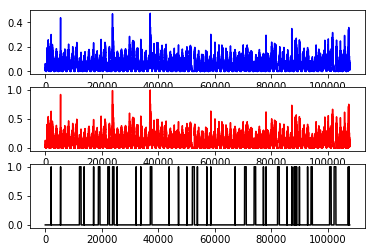

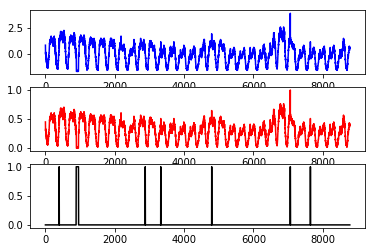

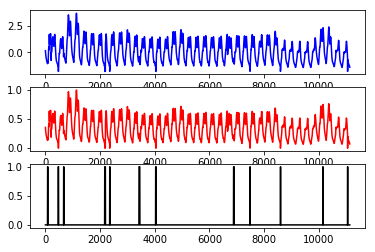

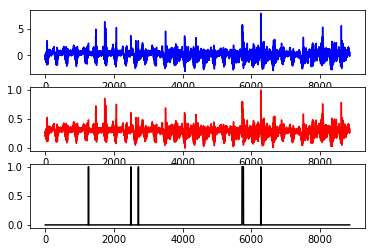

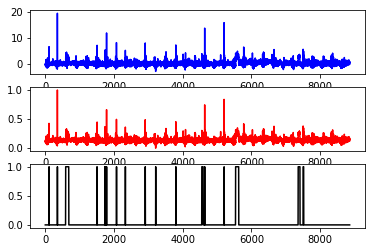

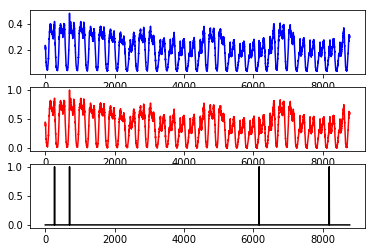

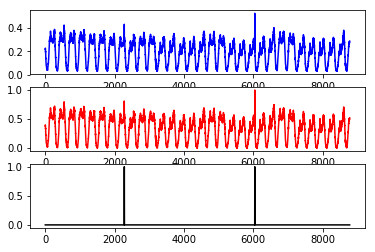

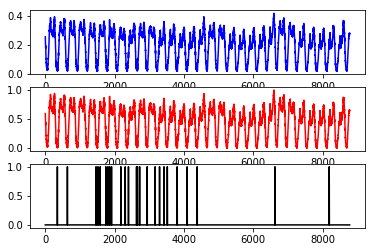

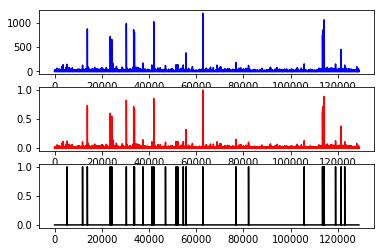

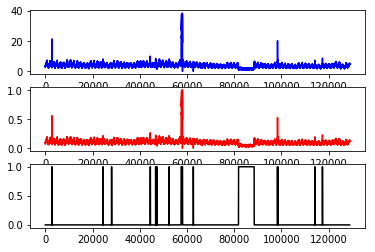

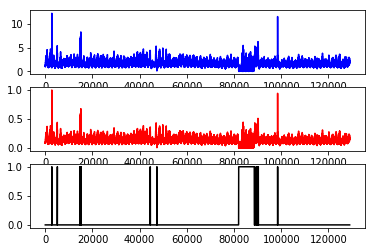

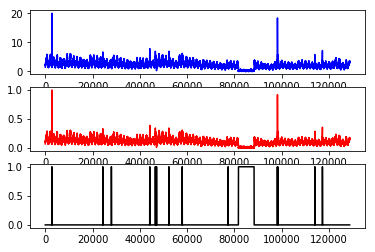

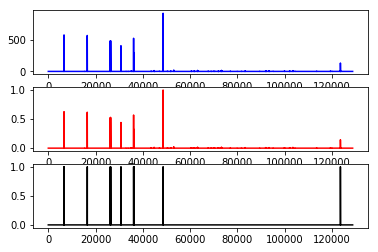

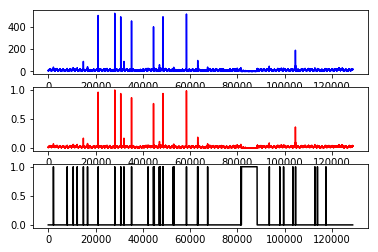

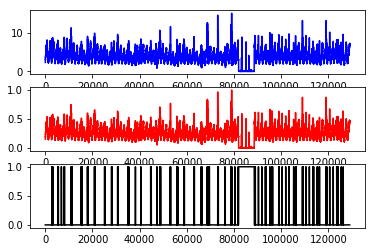

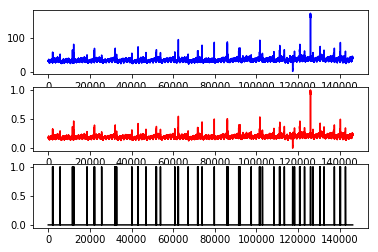

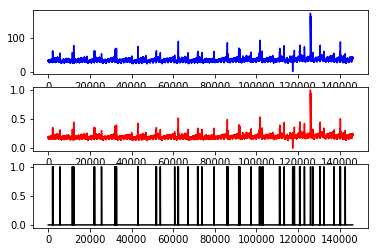

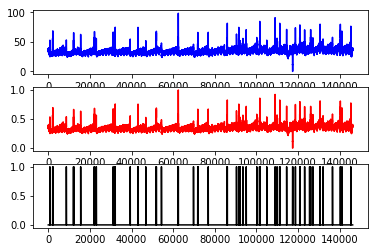

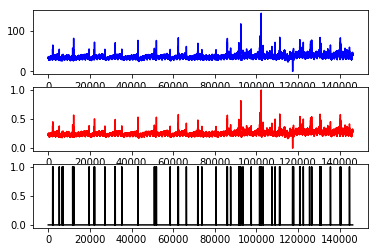

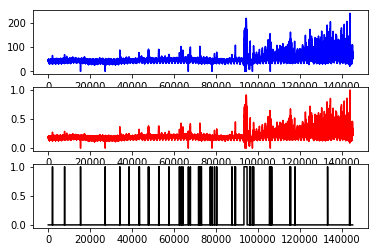

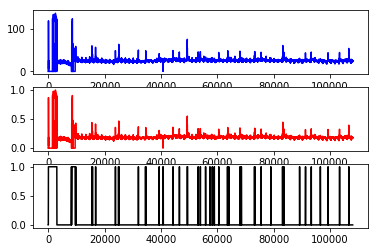

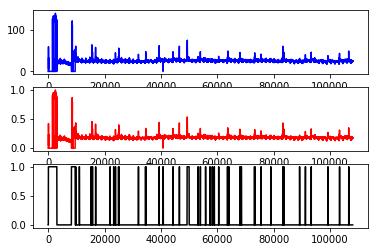

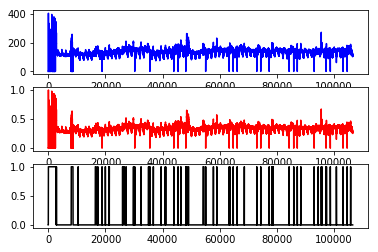

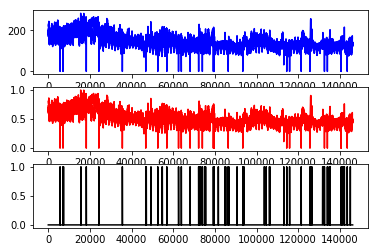

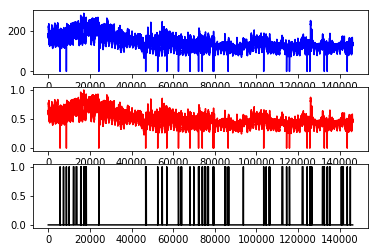

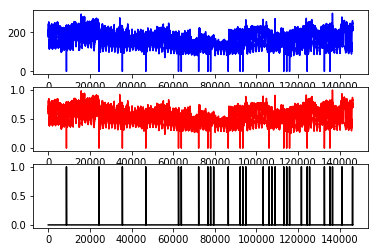

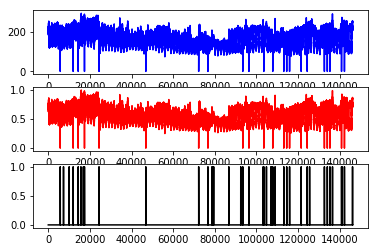

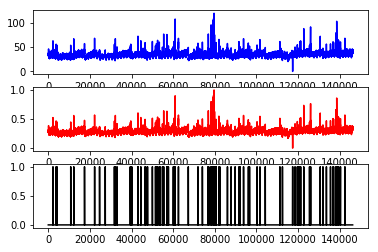

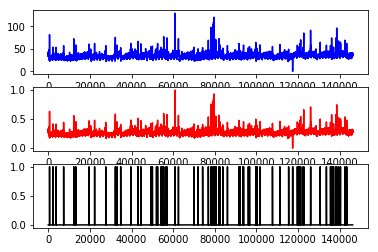

In [26]:
for index in np.arange(train_time_series_dataset_size):

    plt.subplot(3,1,1)
    plt.plot(train_time_series_dataset[index],'b')
    plt.subplot(3,1,2)
    plt.plot(train_time_series_dataset_scaled[index],'r')
    plt.subplot(3,1,3)
    plt.plot(train_time_series_dataset_label[index], 'k')
    plt.show()

0


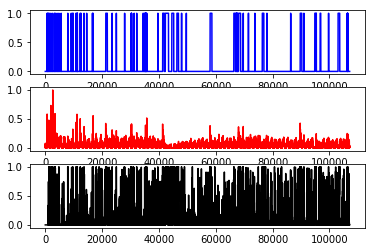

1


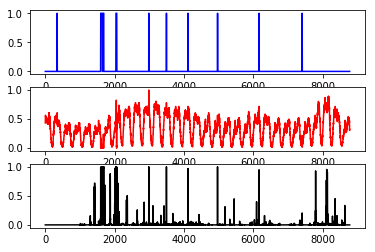

2


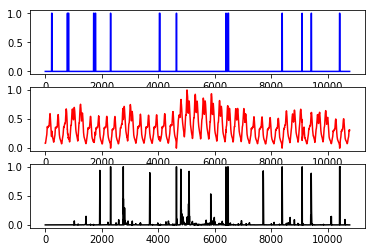

3


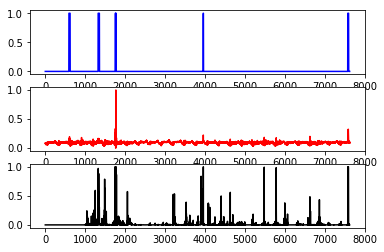

4


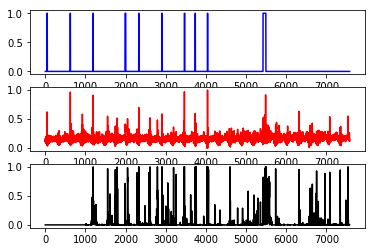

5


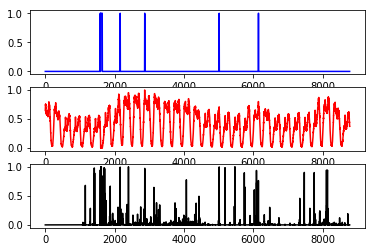

6


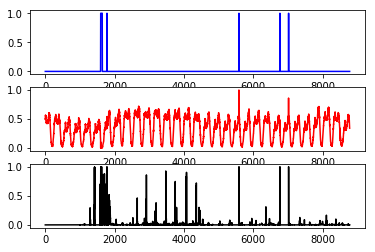

7


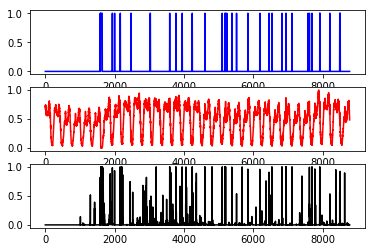

8


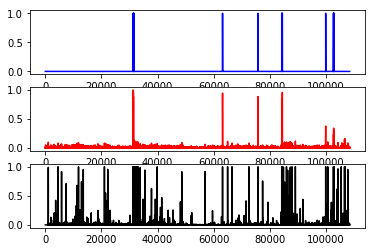

9


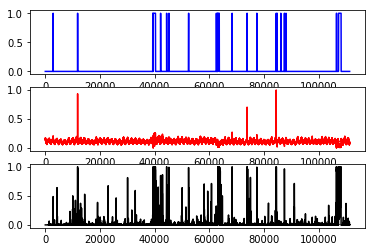

10


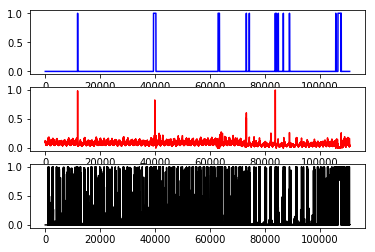

11


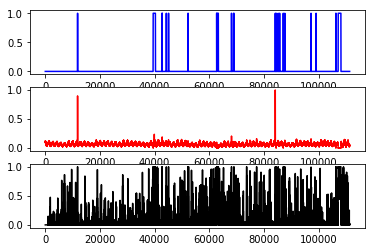

12


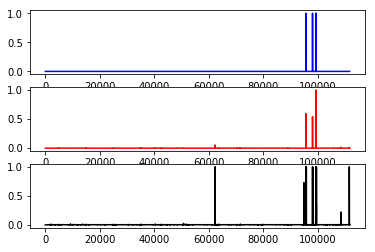

13


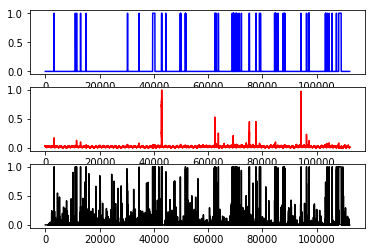

14


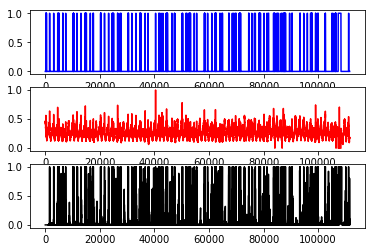

15


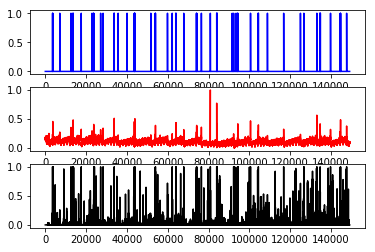

16


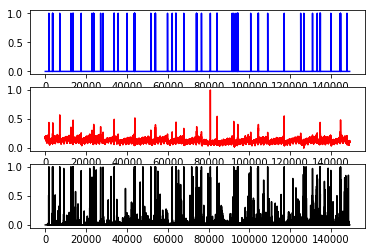

17


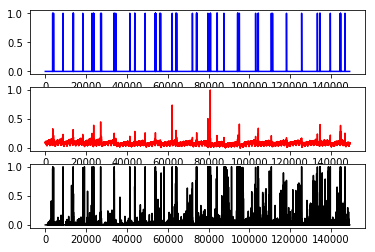

18


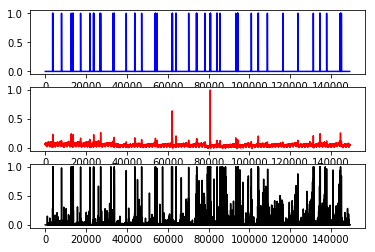

19


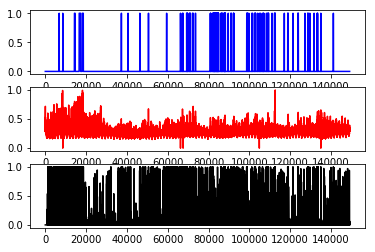

20


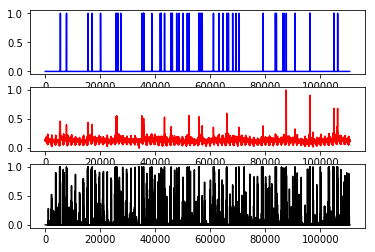

21


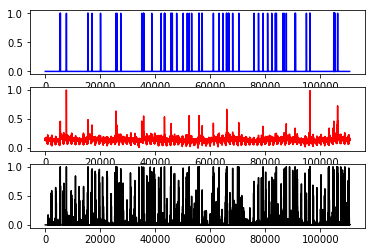

22


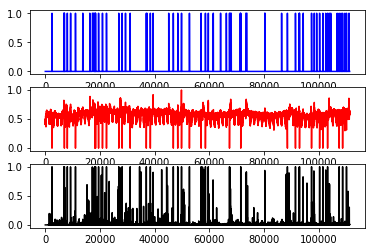

23


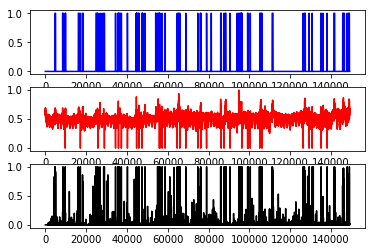

24


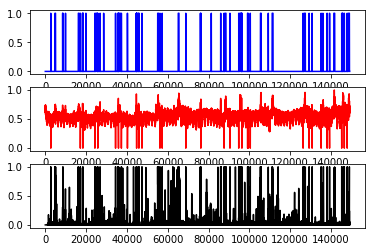

25


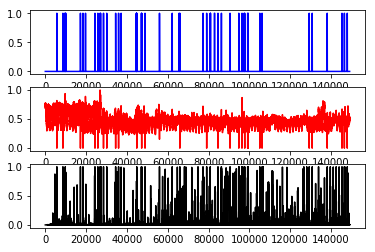

26


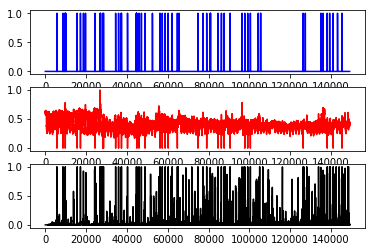

27


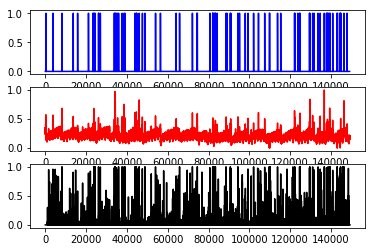

28


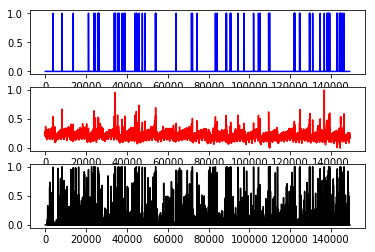

In [27]:
for index in np.arange(test_time_series_dataset_size):            
    print(index)
    plt.subplot(3,1,1)
    plt.plot(test_time_series_dataset_label[index],'b')
    plt.subplot(3,1,2)
    plt.plot(test_time_series_dataset_scaled[index],'r')
    plt.subplot(3,1,3)        
    plt.plot(np.concatenate((np.zeros(2*max(W)), np.ravel(model.predict(np.asarray(test_data_pool[index]))))), 'k')
    plt.show()

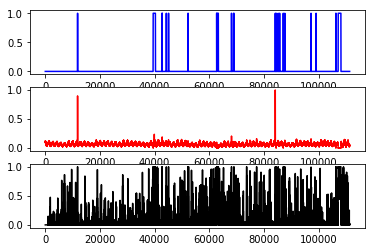

1 0 4


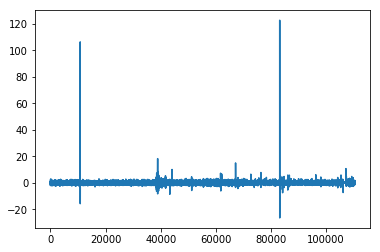

2 0 5


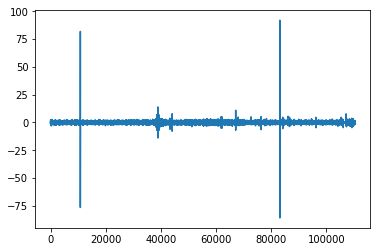

3 0 6


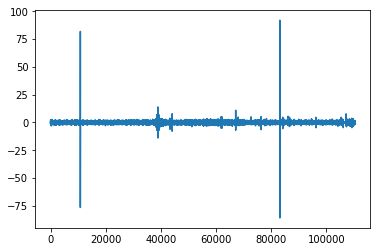

4 0 7


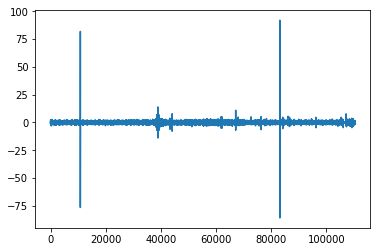

5 0 8


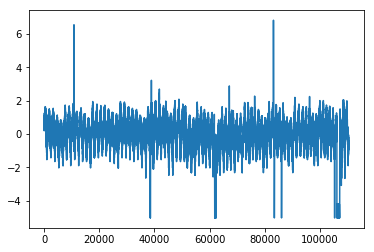

6 0 9


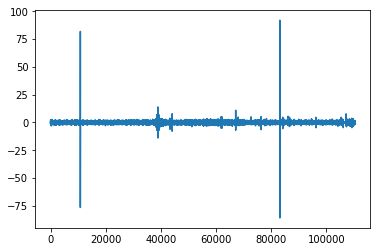

7 0 10


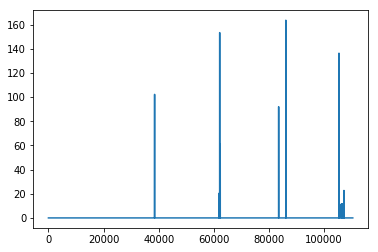

8 0 11


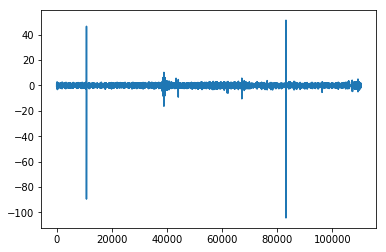

9 0 0


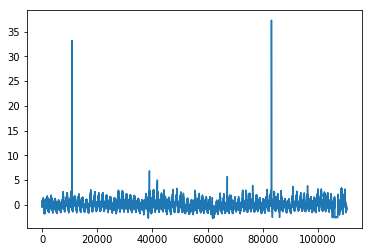

10 1 1


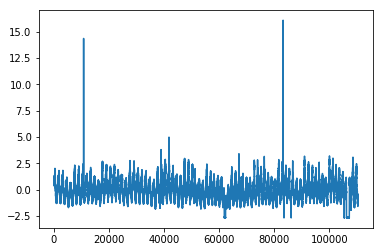

11 1 2


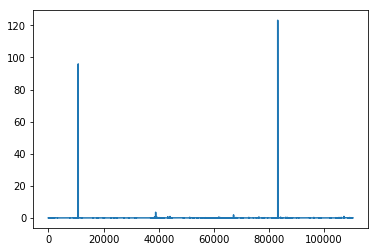

12 1 3


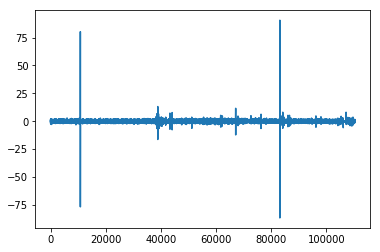

13 1 4


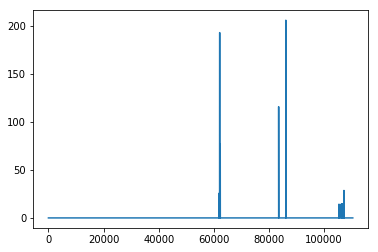

14 1 5


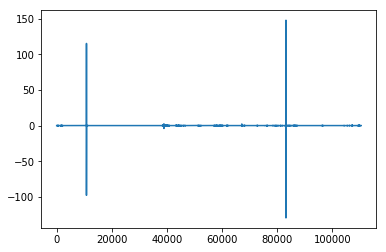

15 1 6


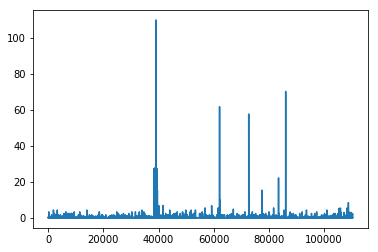

16 1 7


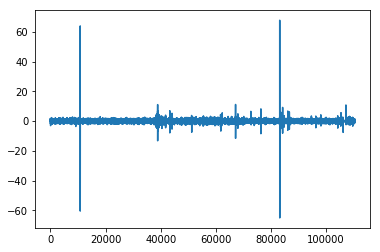

17 1 8


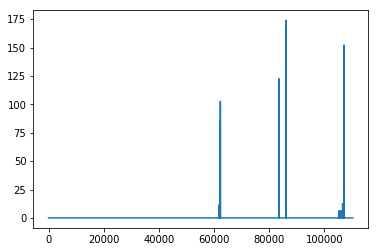

18 1 9


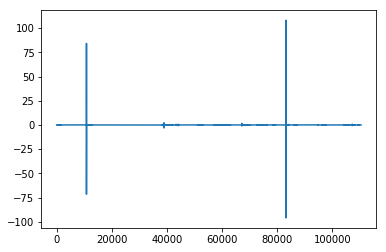

19 1 10


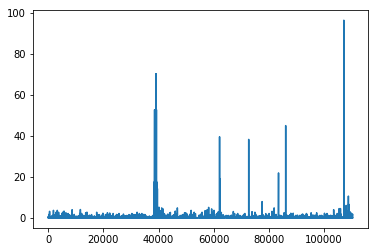

20 1 11


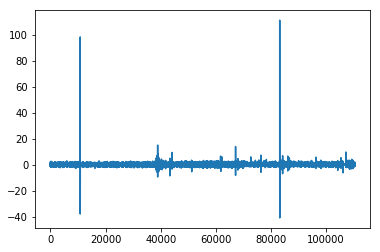

21 1 0


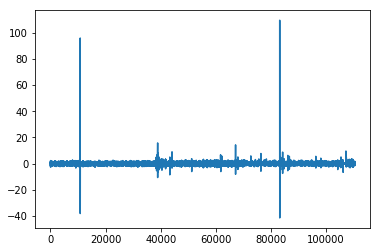

22 2 1


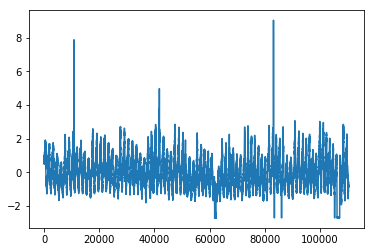

23 2 2


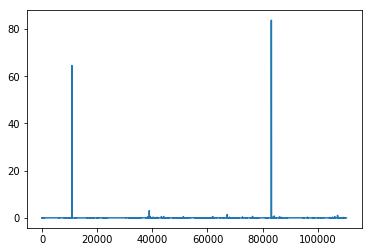

24 2 3


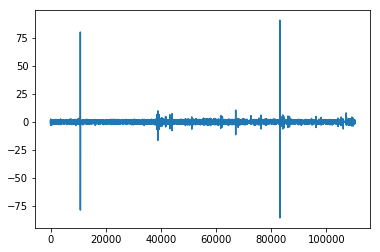

25 2 4


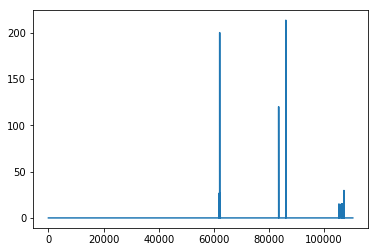

26 2 5


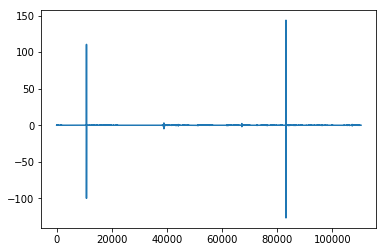

27 2 6


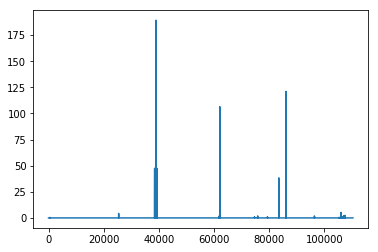

28 2 7


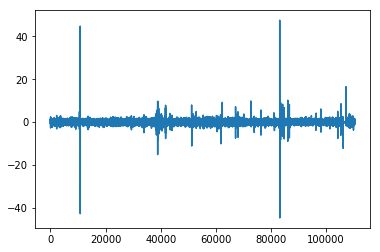

29 2 8


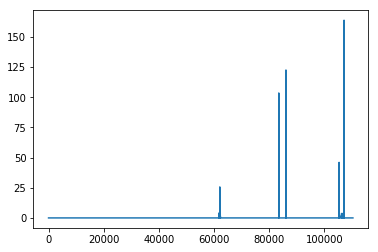

30 2 9


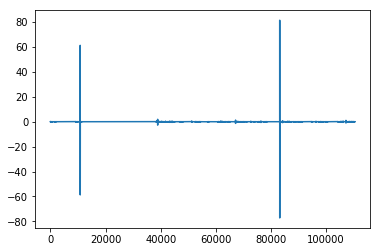

31 2 10


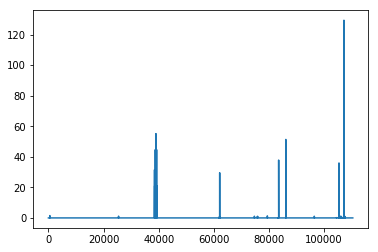

32 2 11


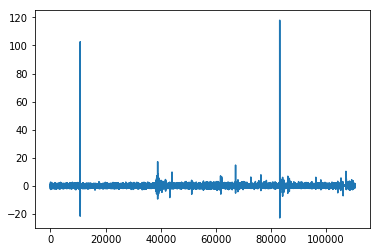

33 2 0


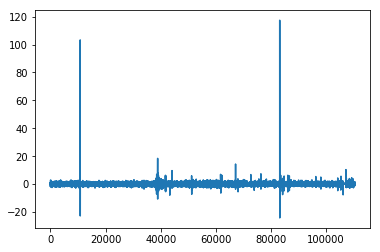

34 3 1


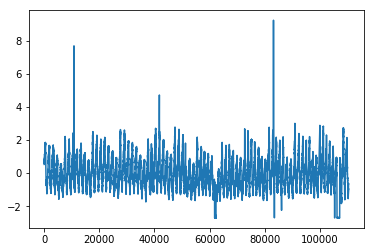

35 3 2


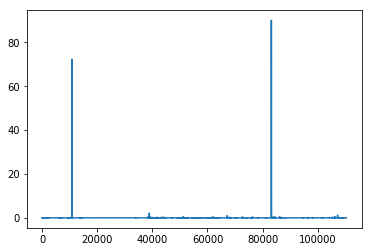

36 3 3


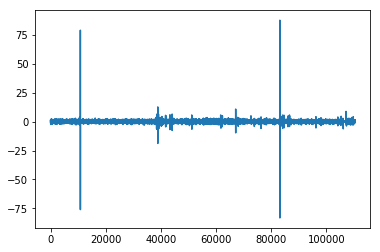

37 3 4


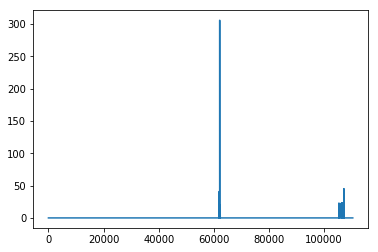

38 3 5


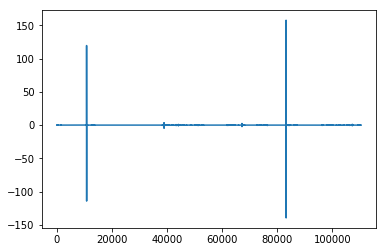

39 3 6


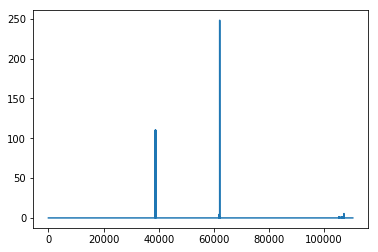

40 3 7


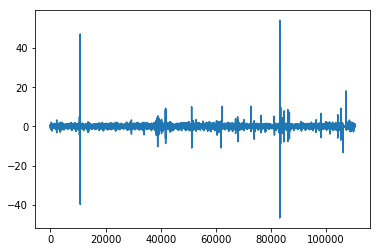

41 3 8


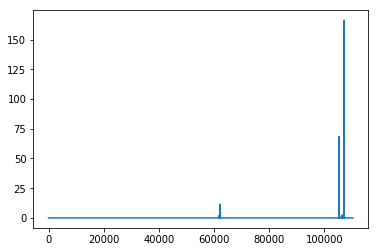

42 3 9


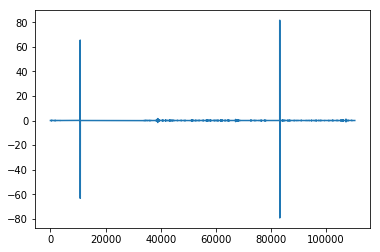

43 3 10


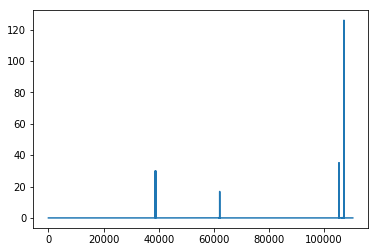

44 3 11


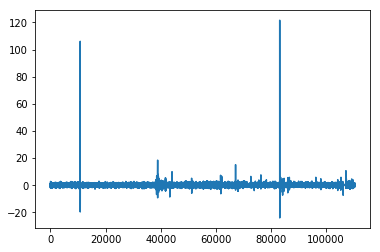

45 3 0


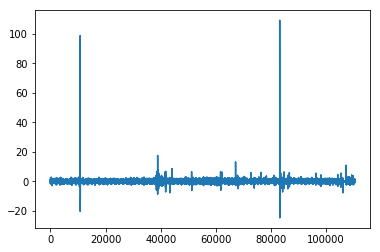

46 4 1


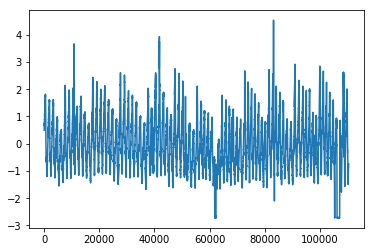

47 4 2


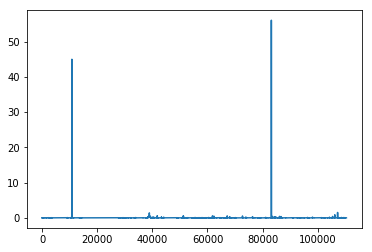

48 4 3


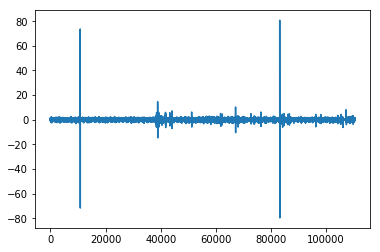

49 4 4


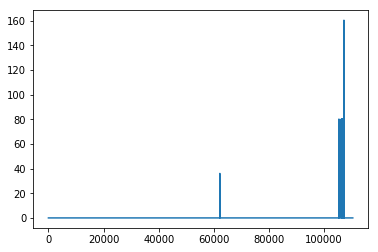

50 4 5


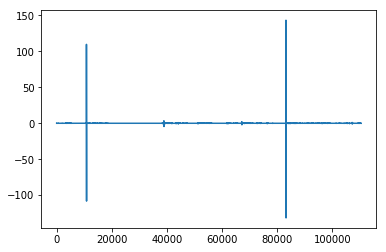

51 4 6


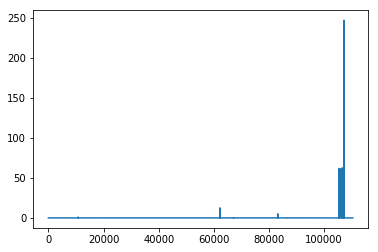

52 4 7


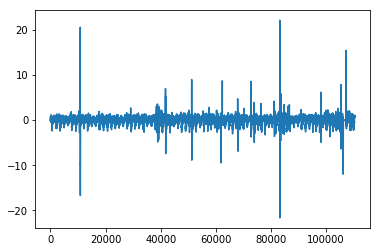

53 4 8


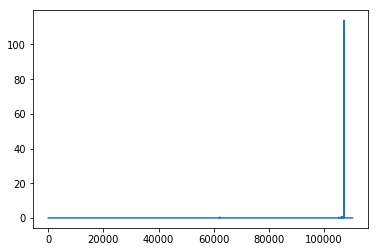

54 4 9


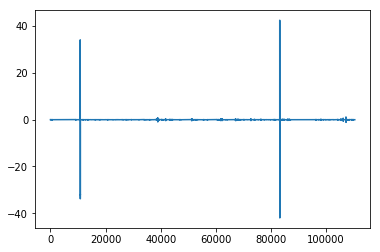

55 4 10


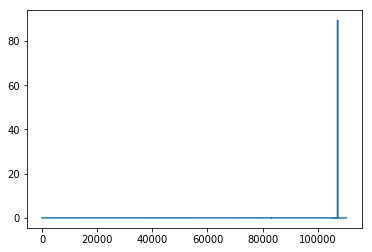

56 4 11


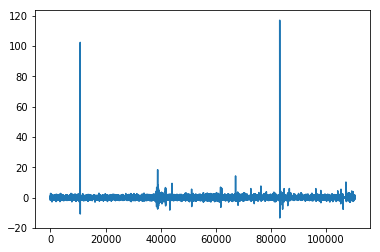

57 4 0


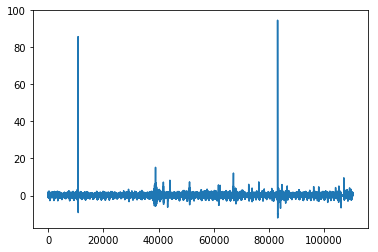

58 5 1


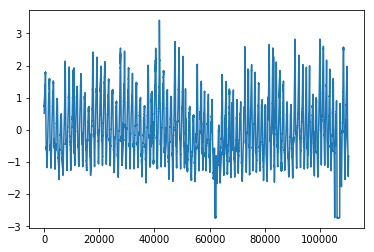

59 5 2


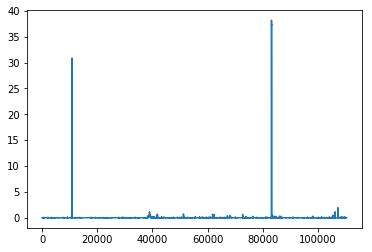

60 5 3


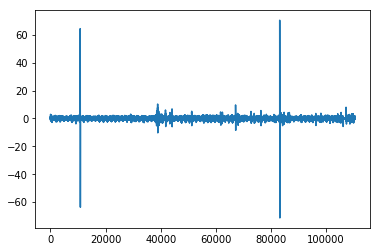

61 5 4


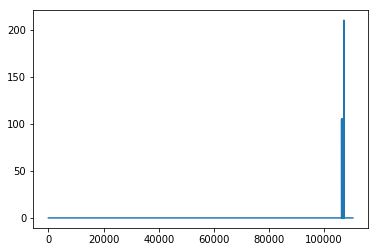

62 5 5


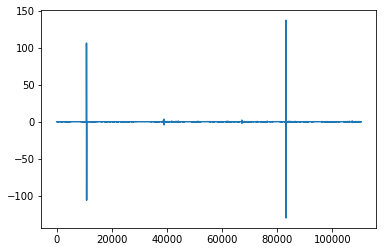

63 5 6


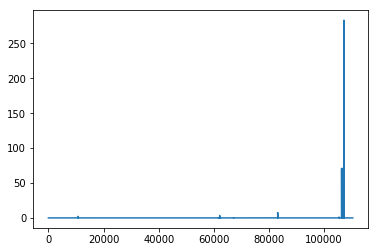

64 5 7


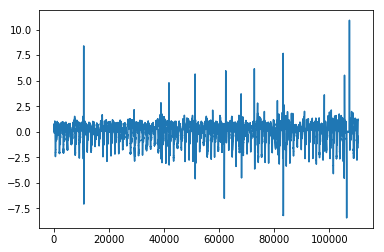

65 5 8


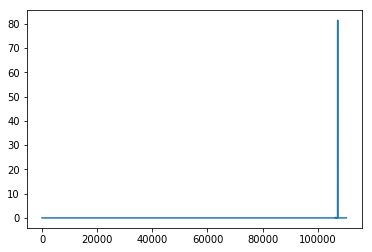

66 5 9


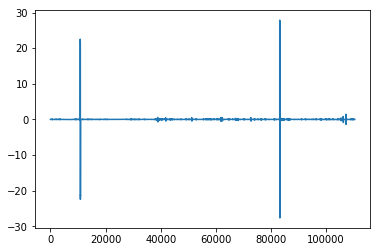

67 5 10


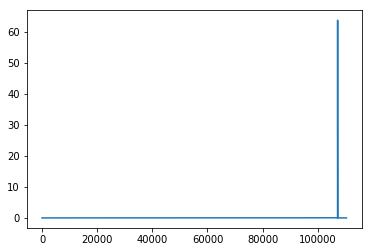

68 5 11


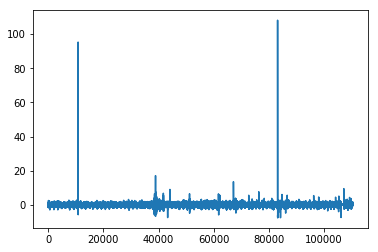

69 5 0


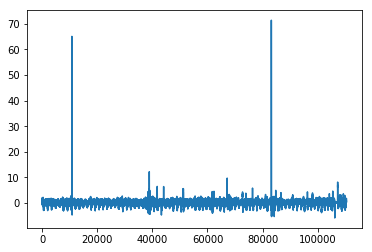

70 6 1


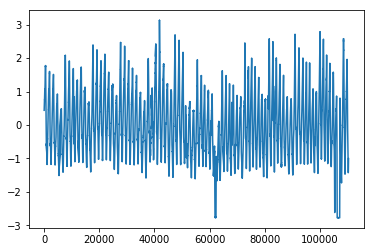

71 6 2


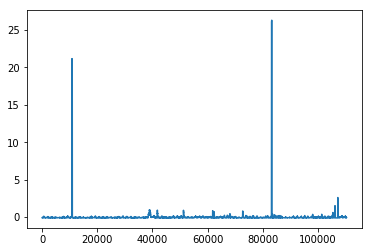

72 6 3


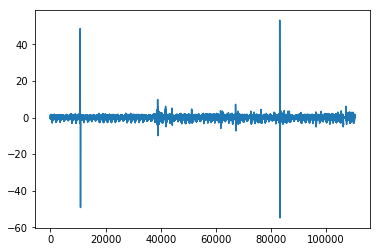

73 6 4


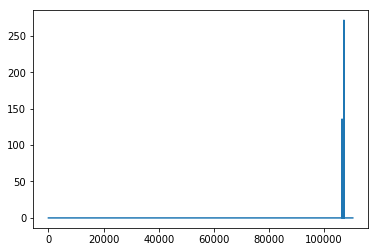

74 6 5


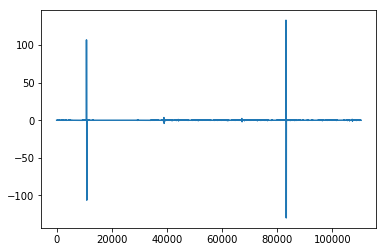

75 6 6


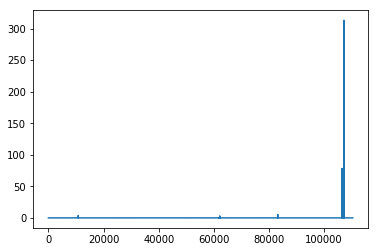

76 6 7


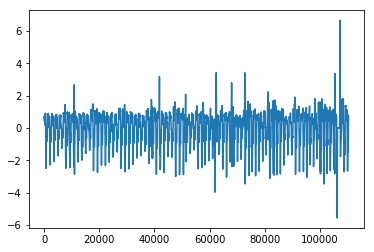

77 6 8


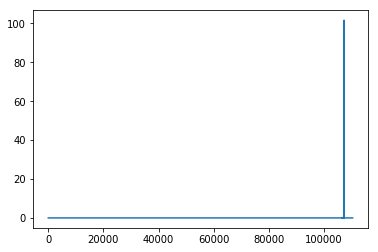

78 6 9


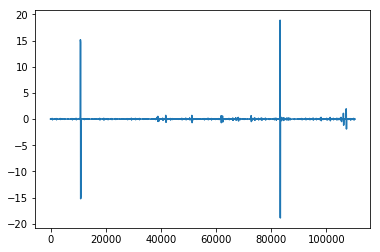

79 6 10


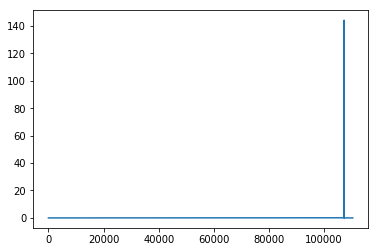

80 6 11


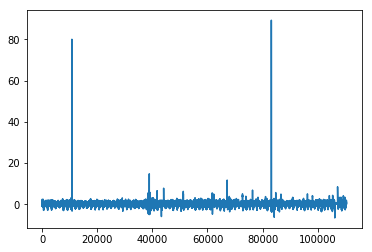

81 6 0


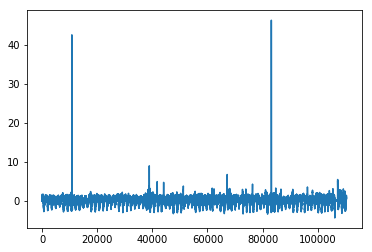

82 7 1


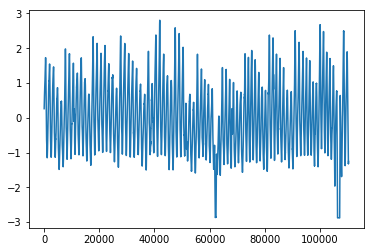

83 7 2


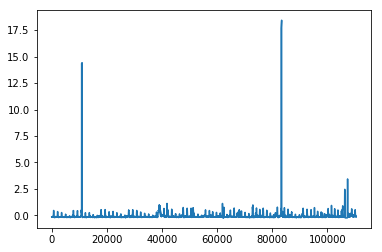

84 7 3


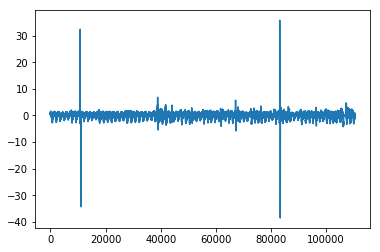

85 7 4


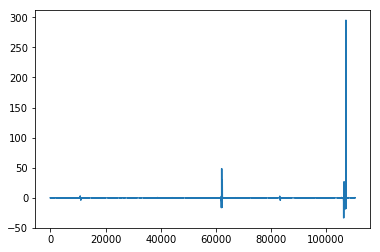

86 7 5


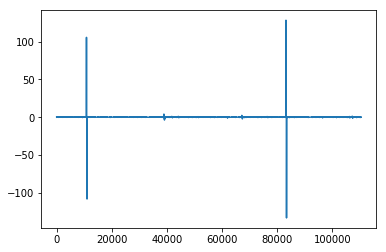

87 7 6


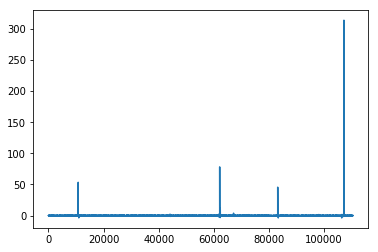

88 7 7


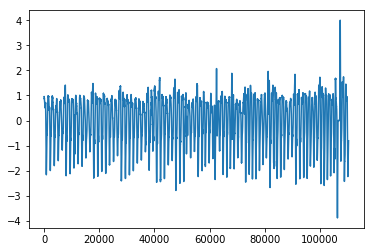

89 7 8


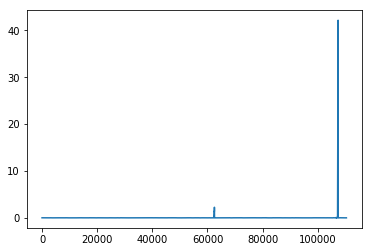

90 7 9


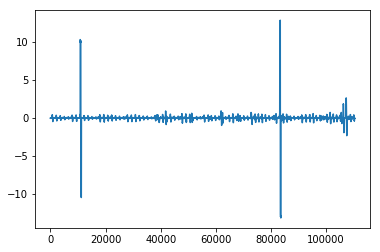

91 7 10


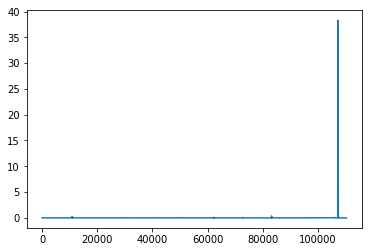

92 7 11


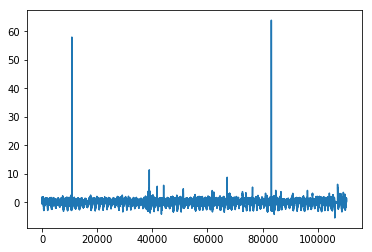

93 7 0


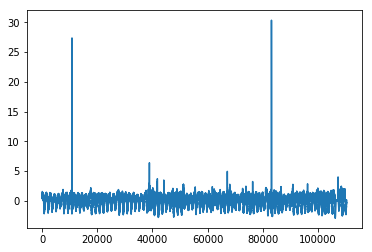

94 8 1


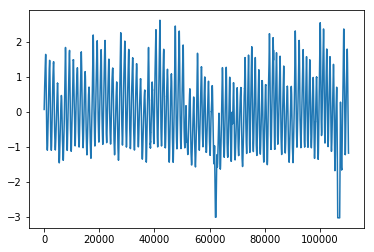

95 8 2


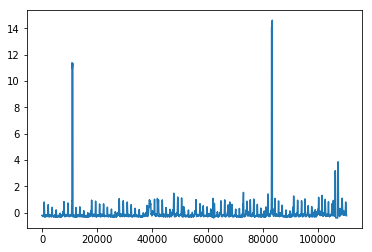

96 8 3


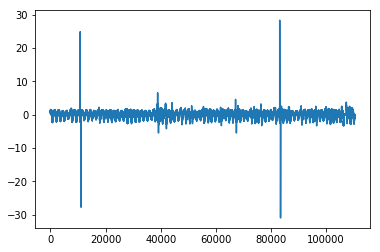

97 8 4


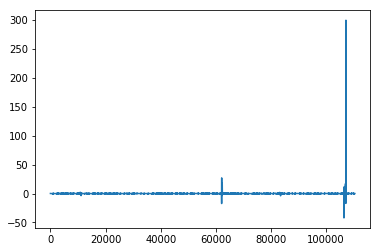

98 8 5


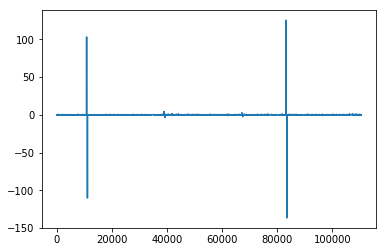

99 8 6


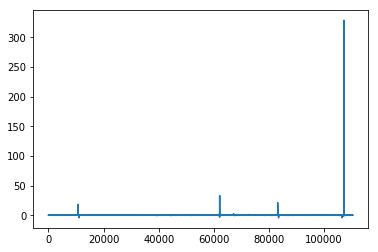

100 8 7


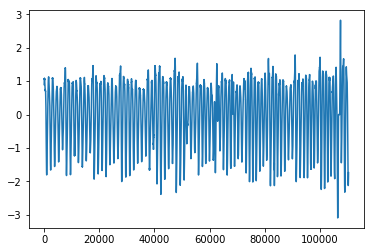

101 8 8


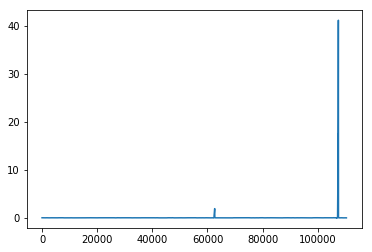

102 8 9


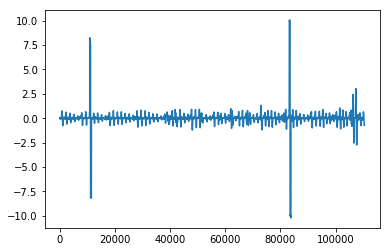

103 8 10


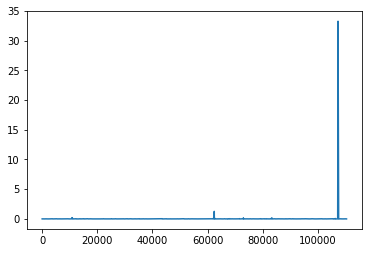

104 8 11


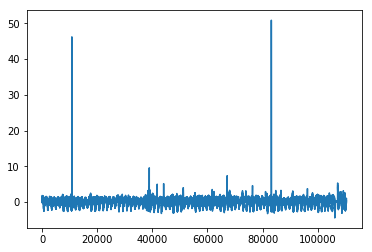

105 8 0


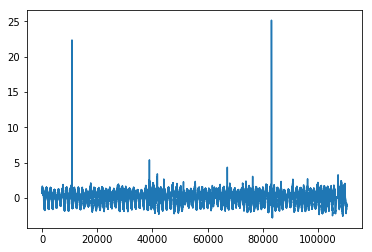

106 9 1


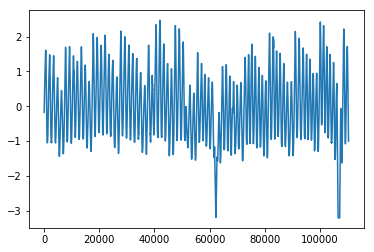

107 9 2


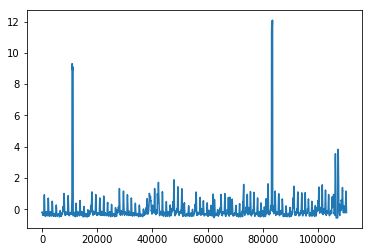

108 9 3


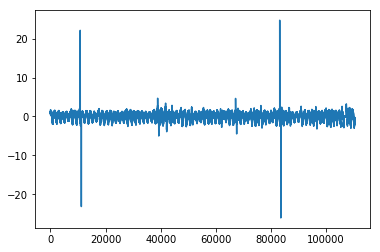

109 9 4


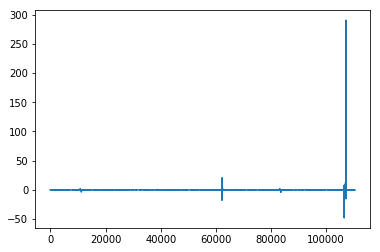

110 9 5


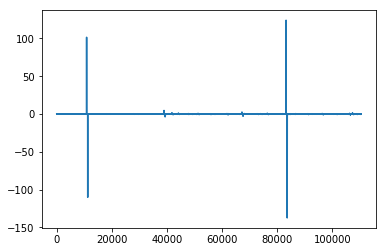

111 9 6


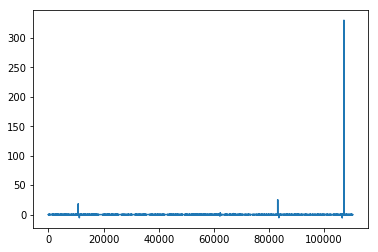

112 9 7


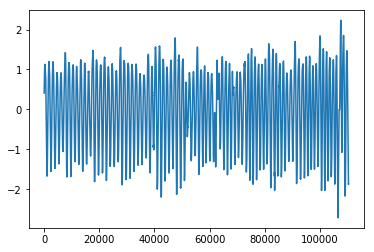

113 9 8


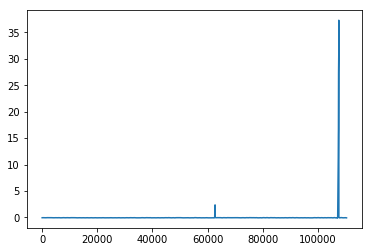

114 9 9


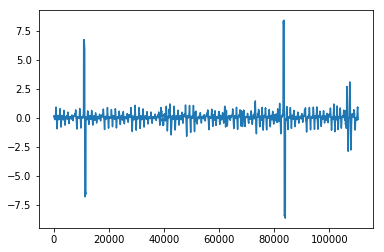

115 9 10


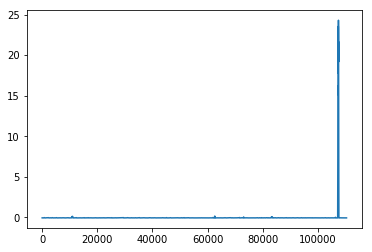

116 9 11


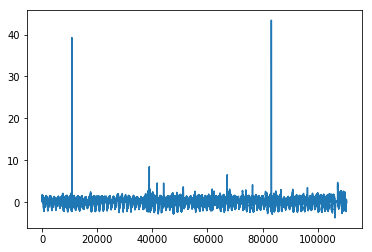

117 9 0


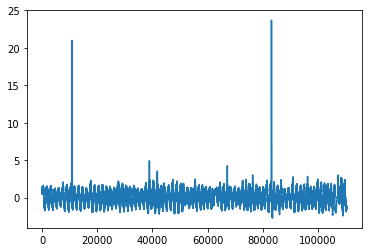

118 10 1


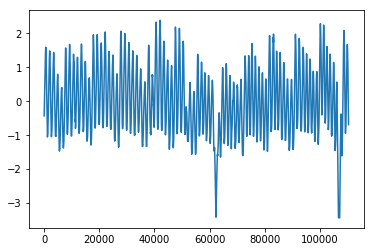

119 10 2


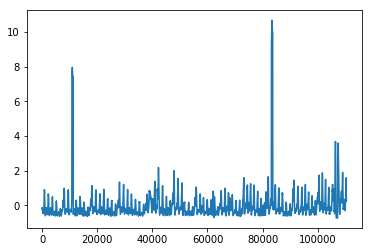

120 10 3


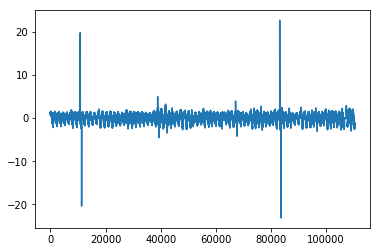

121 10 4


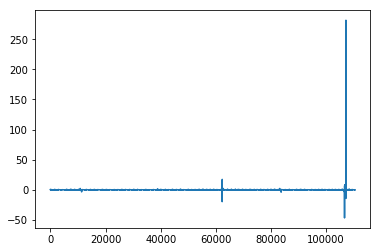

122 10 5


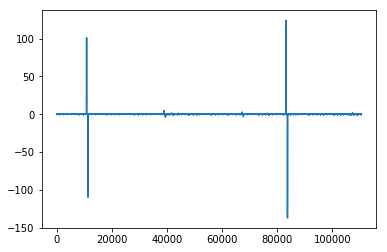

123 10 6


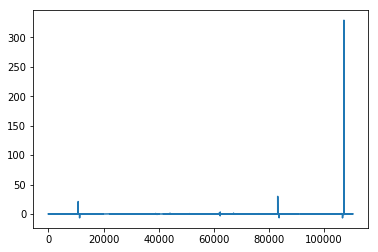

124 10 7


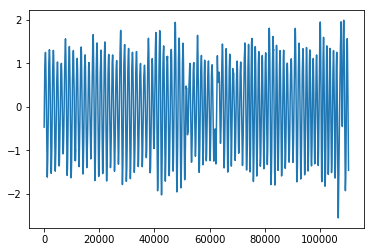

125 10 8


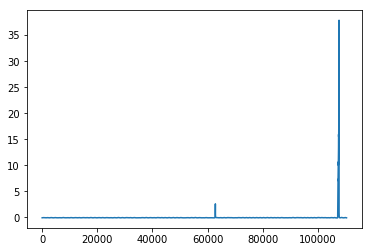

126 10 9


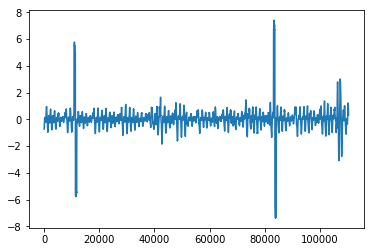

127 10 10


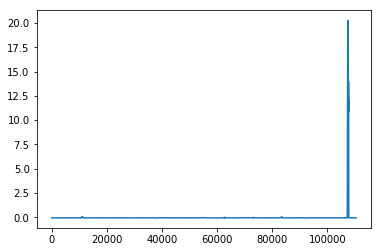

128 10 11


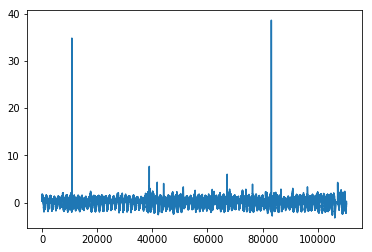

129 10 0


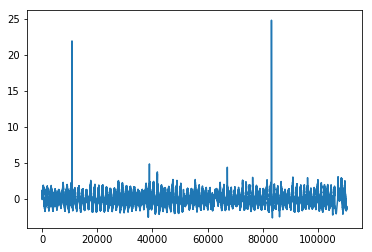

In [28]:
index = 11
        
plt.subplot(3,1,1)
plt.plot(test_time_series_dataset_label[index],'b')
plt.subplot(3,1,2)
plt.plot(test_time_series_dataset_scaled[index],'r')
plt.subplot(3,1,3)
plt.plot(np.concatenate((np.zeros(2*max(W)), np.ravel(model.predict(np.asarray(test_data_pool[index])) ))), 'k')
plt.show()

for fid in np.arange(num_of_feature_with_window * len(W) + num_of_feature_with_value):
    
    sequence = [point[fid] for point in test_data_pool[index]]

    print(fid+1, 
          (fid-num_of_feature_with_value)//num_of_feature_with_window+1, 
          (fid+1-num_of_feature_with_value)%num_of_feature_with_window)
    plt.plot(sequence)
    plt.show()